In [1]:
import pandas as pd
import numpy as np
import re
from mapping_SBS import *


In [3]:
torob = pd.read_csv('DW_models_data_torob.csv')
digikala = pd.read_csv('DW_models_data_digikala.csv')

In [4]:
a = digikala.columns
with open('columns.txt', 'w', encoding='utf-8') as f:
    for i in a:
        f.write(i + '\n')


In [5]:
import pandas as pd

def map_and_merge_columns(df, column_mappings):
    for new_col, old_cols in column_mappings.items():
        matching_cols = [col for col in old_cols if col in df.columns]
        if matching_cols:
            if len(matching_cols) > 1:
                df[new_col] = df[matching_cols].apply(
                    lambda row: next((x for x in row if pd.notna(x) and x != ''), None), axis=1
                )
                df.drop(columns=matching_cols, inplace=True)
            else:
                df.rename(columns={matching_cols[0]: new_col}, inplace=True)

    return df[list(column_mappings.keys())]

digikala_n = map_and_merge_columns(digikala, column_mappings_digikala)
torob1_n = map_and_merge_columns(torob1, column_mappings_torob1)
torob2_n = map_and_merge_columns(torob2, column_mappings_torob2)


In [6]:
digikala_n.shape, torob1_n.shape, torob2_n.shape

((60, 17), (24, 17), (50, 17))

In [7]:
sbs_concate = pd.concat([digikala_n, torob1_n, torob2_n], ignore_index=True)

# Group by 'model_code' and fill missing values with available ones
sbs = sbs_concate.groupby("model_code", as_index=False).first()

In [8]:
threshold = 0.8
sbs = sbs.loc[:, sbs.isnull().mean() < threshold]

data cleaning

In [9]:
def convert_persian_to_english(text):
    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    english_digits = "0123456789"
    trans_table = str.maketrans(persian_digits, english_digits)
    return text.translate(trans_table)
# Apply the conversion function to the entire DataFrame
sbs = sbs.applymap(lambda x: convert_persian_to_english(str(x)) if isinstance(x, str) else x)


C:\Users\atefe\AppData\Local\Temp\ipykernel_12848\2143660812.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sbs = sbs.applymap(lambda x: convert_persian_to_english(str(x)) if isinstance(x, str) else x)


In [10]:
sbs['energy_rating'].unique()
sbs['energy_rating'] = sbs['energy_rating'].replace({r'^\+A$': 1, r'^A\+\+$': 2,r'^A$': 0, r'^A\+$': 1}, regex=True)
sbs['energy_rating'].value_counts()

energy_rating
1.0    78
2.0     9
0.0     5
Name: count, dtype: int64

In [11]:

sbs[sbs["total_capacity_feet"].isna() & sbs["total_capacity"].str.contains("فوت", na=False)]
sbs["total_capacity"] = sbs["total_capacity"].apply(lambda x: np.nan if isinstance(x, str) and "فوت" in x else x)
sbs['total_capacity'].unique()

array(['بیش از 700 لیتر', None, '551 تا 700', '771 لیتر', '684 لیتر',
       '520 لیتر', nan, '719لیتر', '491 تا 550', '351 تا 490', '800 لیتر',
       '719', '667 لیتر', '777 لیتر', '501 لیتر', 556.0, '597 لیتر'],
      dtype=object)

In [12]:
total_capacity_mapping = {
    'بیش از 700 لیتر':3, None:np.nan, '551 تا 700':2, '771 لیتر':3, '684 لیتر':2,
       '520 لیتر':1, 'nan' :np.nan, '719لیتر':3, '491 تا 550':1, '351 تا 490':0, '800 لیتر':3,
       '719':2, '667 لیتر':2, '777 لیتر':3, '501 لیتر':1, 556.0:2, '597 لیتر':2
}
sbs['total_capacity_mapped'] = sbs['total_capacity'].map(total_capacity_mapping)

In [13]:
valuse = sbs['total_capacity'].unique()
for value in valuse:
    if isinstance(value, str):
        if 'لیتر' in value:
            print(value)



بیش از 700 لیتر
771 لیتر
684 لیتر
520 لیتر
719لیتر
800 لیتر
667 لیتر
777 لیتر
501 لیتر
597 لیتر


In [14]:
sbs = sbs.replace({'عدد': '', 'کیلوگرم': '','فوت':'','لیتر':'','لستر':'','طبقه':'','تومان':'','کشو':'','ناموجود':'','- ':'','در یخچال':''}, regex=True)
sbs = sbs.replace({'':np.nan})
sbs.requires_water_connection = sbs.requires_water_connection.replace({'بله':1,'دارد':1,'ندارد':0})
sbs.number_of_freezer_drawers = sbs.number_of_freezer_drawers.replace('ندارد',0)
sbs.no_frost = sbs.no_frost.replace({'نوفراست':1,'بله':1,'دارد':1,'بلی':1,'yes':1})

In [15]:
# Assuming df is your dataframe and the column is named 'price'
sbs['price'] = sbs['price'].replace({'٫': '', ' ': ''}, regex=True)

# Convert the 'price' column to float
sbs['price'] = pd.to_numeric(sbs['price'], errors='coerce')

In [16]:
sbs.drop(['total_capacity','noise_level','no_frost','requires_water_connection'], axis=1, inplace=True)

filling nulls

In [17]:
sbs['energy_rating'] = sbs['energy_rating'].fillna(sbs['energy_rating'].mode()[0])

In [18]:
# Rule 1: Remove rows where all columns are null
sbs = sbs.dropna(subset=['fridge_capacity', 'freezer_capacity', 'total_capacity_feet', 'total_capacity_mapped'], how='all')
def fill_capacity_based_on_total_capacity(row):
    if pd.isnull(row['fridge_capacity']) or pd.isnull(row['freezer_capacity']):
        similar_row = sbs.dropna(subset=['total_capacity_feet', 'total_capacity_mapped']).iloc[0]
        row['fridge_capacity'] = similar_row['fridge_capacity'] if pd.isnull(row['fridge_capacity']) else row['fridge_capacity']
        row['freezer_capacity'] = similar_row['freezer_capacity'] if pd.isnull(row['freezer_capacity']) else row['freezer_capacity']
    return row

sbs = sbs.apply(fill_capacity_based_on_total_capacity, axis=1)
def fill_similar_total_capacity_mapped(row):
    if pd.isnull(row['total_capacity_mapped']):
        # Find rows with similar values in 'fridge_capacity', 'freezer_capacity', and 'total_capacity_mapped'
        similar_rows = sbs.dropna(subset=['total_capacity_mapped'])  # Drop rows with missing 'total_capacity_feet'
        
        # Find rows that match based on the other columns
        matching_rows = similar_rows[
            (similar_rows['fridge_capacity'] == row['fridge_capacity']) &
            (similar_rows['freezer_capacity'] == row['freezer_capacity'])
        ]
        
        if not matching_rows.empty:
            # Take the most frequent 'total_capacity_feet' from matching rows
            most_frequent_value = matching_rows['total_capacity_mapped'].mode()[0]
            row['total_capacity_mapped'] = most_frequent_value
        else:
            total = int(row['fridge_capacity']) + int(row['freezer_capacity'])
            if total < 490:
                row['total_capacity_mapped'] = 0
            elif total < 550:
                row['total_capacity_mapped'] = 1
            elif total < 700:
                row['total_capacity_mapped'] = 2
            elif total > 700:
                row['total_capacity_mapped'] = 3

    return row

sbs = sbs.apply(fill_similar_total_capacity_mapped, axis=1)
# Rule 3: If 'total_capacity_feet' is missing, find similar rows and replace with the most frequent value
def fill_similar_total_capacity_feet(row):
    if pd.isnull(row['total_capacity_feet']):
        # Find rows with similar values in 'fridge_capacity', 'freezer_capacity', and 'total_capacity_mapped'
        similar_rows = sbs.dropna(subset=['total_capacity_feet'])  # Drop rows with missing 'total_capacity_feet'
        
        # Find rows that match based on the other columns
        matching_rows = similar_rows[
            ((similar_rows['fridge_capacity'] == row['fridge_capacity']) &
            (similar_rows['freezer_capacity'] == row['freezer_capacity'])
        )| (similar_rows['total_capacity_mapped'] == row['total_capacity_mapped'])]
        
        if not matching_rows.empty:
            # Take the most frequent 'total_capacity_feet' from matching rows
            most_frequent_value = matching_rows['total_capacity_feet'].mode()[0]
            row['total_capacity_feet'] = most_frequent_value

    return row

sbs = sbs.apply(fill_similar_total_capacity_feet, axis=1)

In [19]:
sbs['number_of_fridge_shelves'] = sbs['number_of_fridge_shelves'].fillna(sbs['number_of_fridge_shelves'].mode()[0])
sbs['number_of_freezer_shelves']= sbs['number_of_freezer_shelves'].fillna(sbs['number_of_freezer_shelves'].mode()[0])
sbs['number_of_fridge_door_shelves'] = sbs['number_of_fridge_door_shelves'].fillna(sbs['number_of_fridge_door_shelves'].mode()[0])
sbs['number_of_freezer_door_shelves'] = sbs['number_of_freezer_door_shelves'].fillna(sbs['number_of_freezer_door_shelves'].mode()[0])
sbs['number_of_fridge_drawers'] = sbs['number_of_fridge_drawers'].fillna(sbs['number_of_fridge_drawers'].mode()[0])
sbs['number_of_freezer_drawers'] = sbs['number_of_freezer_drawers'].fillna(sbs['number_of_freezer_drawers'].mode()[0])

In [20]:
sbs['weight'] = pd.to_numeric(sbs['weight'], errors='coerce')
sbs['weight'] = sbs['weight'].fillna(sbs.groupby('total_capacity_mapped')['weight'].transform('mean'))
sbs['price'] = sbs['price'].fillna(sbs.groupby('total_capacity_mapped')['price'].transform('mean'))

In [21]:
null_counts = sbs.isnull().sum()

print(null_counts)

model_code                        0
fridge_capacity                   0
freezer_capacity                  0
energy_rating                     0
total_capacity_feet               0
number_of_fridge_shelves          0
number_of_freezer_shelves         0
number_of_fridge_door_shelves     0
number_of_freezer_door_shelves    0
number_of_fridge_drawers          0
number_of_freezer_drawers         0
weight                            0
price                             0
total_capacity_mapped             0
dtype: int64


clustering

In [141]:
sbs_cp = sbs.copy()
sbs_cp.drop(['model_code'], axis=1, inplace=True)
sbs_cp.shape

(91, 17)

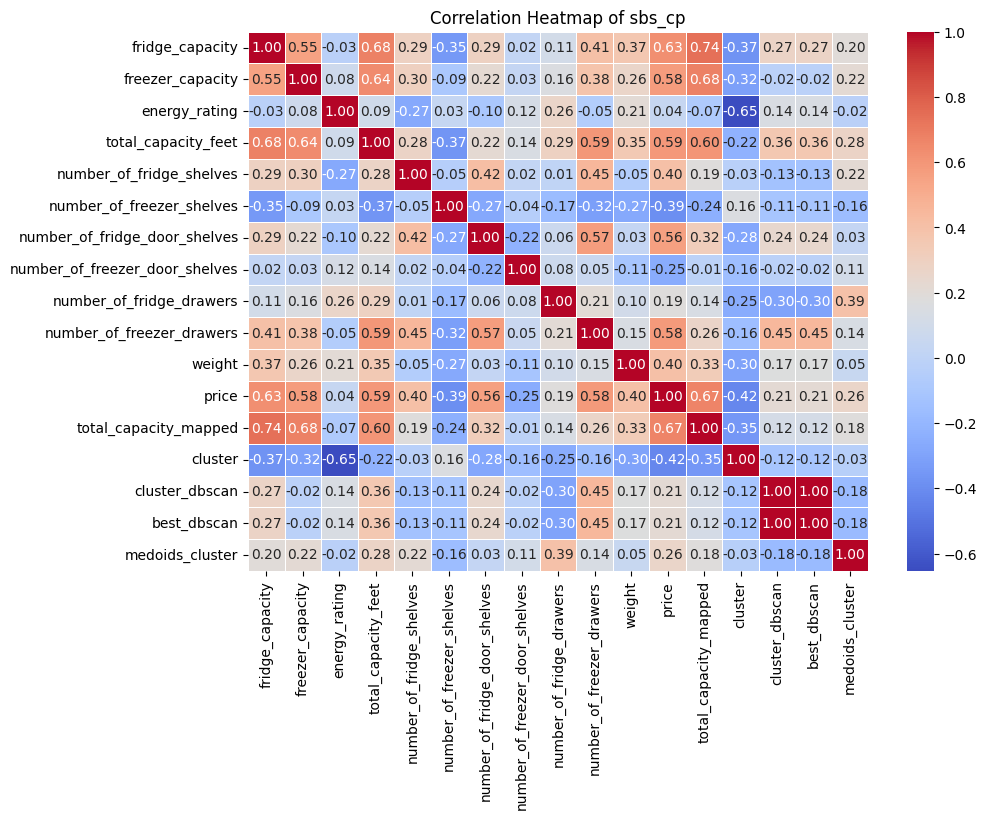

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = sbs_cp.corr()

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Title
plt.title("Correlation Heatmap of sbs_cp")

# Show plot
plt.show()


In [145]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Assuming df is your dataframe
scaler =MinMaxScaler()
df_scaled = scaler.fit_transform(sbs_cp)


finding number of cluster for kmeans with elbow method

c:\Users\atefe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\atefe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\atefe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\atefe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

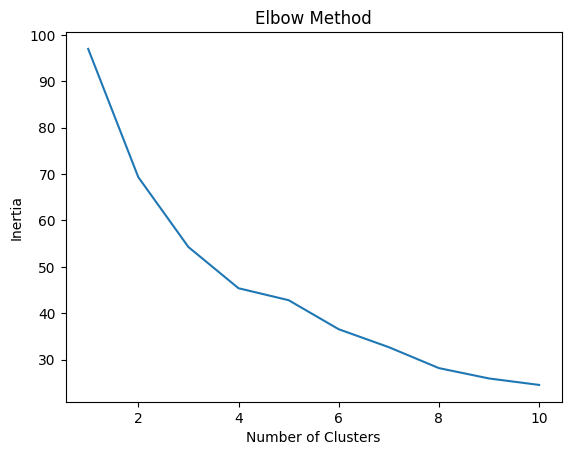

In [146]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [188]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
kmeans = KMeans(n_clusters=3,n_init='warn', random_state=42)
sbs['cluster'] = kmeans.fit_predict(df_scaled)
# internal Evaluation Metrics
score = silhouette_score(sbs_cp, sbs['cluster'])  # X = dataset, labels = cluster assignments
print(f"Silhouette Score: {score:.3f}") #Closer to 1 → Well-defined clusters

dbi = davies_bouldin_score(sbs_cp, sbs['cluster'])
print(f"Davies-Bouldin Index: {dbi:.3f}") #Lower values indicate better clustering.

ch = calinski_harabasz_score(sbs_cp, sbs['cluster'])
print(f"Calinski-Harabasz Index: {ch:.3f}") #Higher values indicate better clustering.

# Add the cluster labels to the original dataframe
print(sbs[['model_code', 'cluster']].head())


Silhouette Score: 0.184
Davies-Bouldin Index: 1.900
Calinski-Harabasz Index: 93.614
               model_code  cluster
0  DAEWOO-SBS-ARSXi30-20S        0
1  DAEWOO-SBS-ARSXi30-30S        0
2  DAEWOO-SBS-ARSXi30-30W        0
3   DAEWOO-SBS-D5S-0036SS        1
4    DAEWOO-SBS-DS-3020GW        1


c:\Users\atefe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


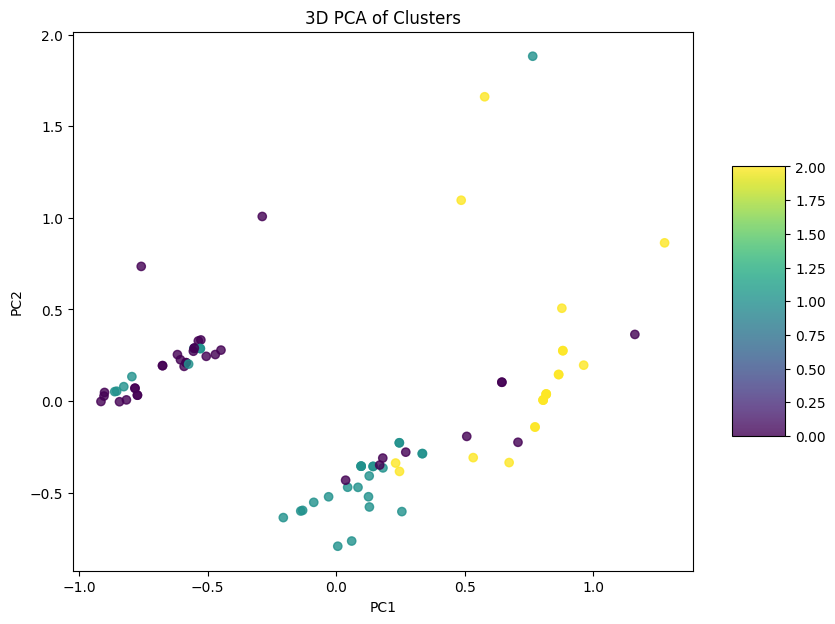

In [189]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Reduce to 3D for visualization
pca = PCA(n_components=2,svd_solver='full')
df_pca = pca.fit_transform(df_scaled)

# Create a DataFrame for the reduced features and cluster labels
df_pca_df = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca_df['cluster'] = sbs['cluster']

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

# Scatter plot with cluster colors
scatter = ax.scatter(df_pca_df['PC1'], df_pca_df['PC2'], 
                     c=df_pca_df['cluster'], cmap='viridis', alpha=0.8)

# Labels and title
ax.set_title('3D PCA of Clusters')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Add color bar
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

# Show plot
plt.show()


<h1>DBSCAN</h1>

finding min_sample

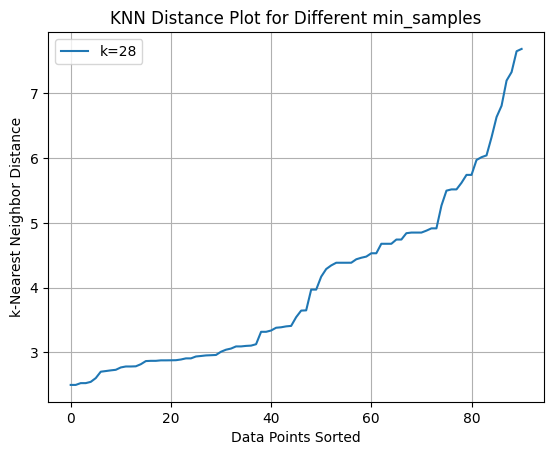

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

for k in [5,10,15]:  # Test different min_samples values
    nbrs = NearestNeighbors(n_neighbors=k).fit(df_scaled)
    distances, indices = nbrs.kneighbors(df_scaled)
    
    sorted_distances = np.sort(distances[:, k-1])  # k-th nearest neighbor
    plt.plot(sorted_distances, label=f'k={k}')

plt.xlabel("Data Points Sorted")
plt.ylabel("k-Nearest Neighbor Distance")
plt.title("KNN Distance Plot for Different min_samples")
plt.legend()
plt.grid()
plt.show()


In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

# Apply DBSCAN
dbscan = DBSCAN(eps=1, min_samples=5)  # Adjust eps & min_samples as needed
sbs['cluster_dbscan'] = dbscan.fit_predict(df_scaled)  # Assign cluster labels

score = silhouette_score(sbs_cp, sbs['cluster_dbscan'])  # X = dataset, labels = cluster assignments
print(f"Silhouette Score: {score:.3f}") #Closer to 1 → Well-defined clusters

dbi = davies_bouldin_score(sbs_cp, sbs['cluster_dbscan'])
print(f"Davies-Bouldin Index: {dbi:.3f}") #Lower values indicate better clustering.

ch = calinski_harabasz_score(sbs_cp, sbs['cluster_dbscan'])
print(f"Calinski-Harabasz Index: {ch:.3f}") #Higher values indicate better clustering.


Silhouette Score: 0.014
Davies-Bouldin Index: 2.404
Calinski-Harabasz Index: 16.028


In [ ]:
# sbs['best_dbscan']=best_labels

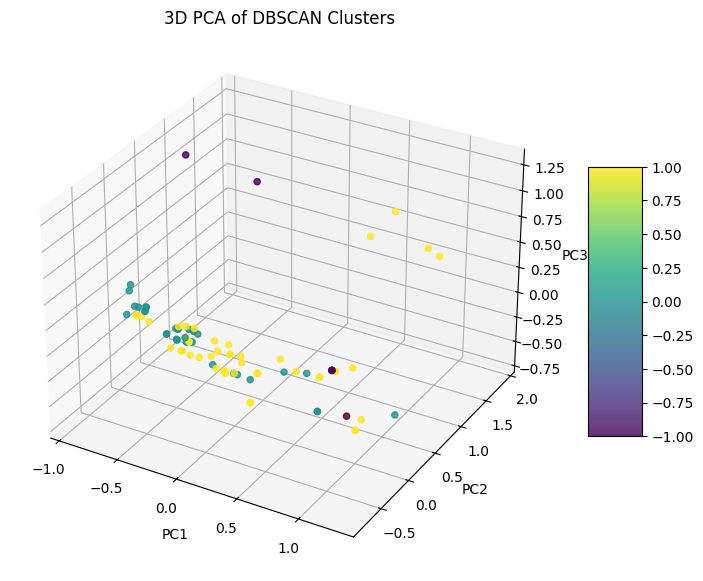

In [159]:
# Reduce to 3D for visualization using PCA
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_scaled)

# Create a DataFrame for visualization
df_pca_df = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca_df['cluster'] = sbs['cluster_dbscan']  # Add DBSCAN cluster labels

# Plot 3D Scatter
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot points, coloring them by cluster
scatter = ax.scatter(df_pca_df['PC1'], df_pca_df['PC2'], df_pca_df['PC3'], 
                     c=df_pca_df['cluster'], cmap='viridis', alpha=0.8)

# Labels and title
ax.set_title('3D PCA of DBSCAN Clusters')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Add color bar
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

# Show plot
plt.show()


In [160]:
sbs.cluster_dbscan.value_counts()

cluster_dbscan
 1    51
 0    33
-1     7
Name: count, dtype: int64

In [67]:
sbs[sbs['cluster']==1]

,model_code,fridge_capacity,freezer_capacity,energy_rating,total_capacity_feet,number_of_fridge_shelves,number_of_freezer_shelves,number_of_fridge_door_shelves,number_of_freezer_door_shelves,number_of_fridge_drawers,number_of_freezer_drawers,weight,price,total_capacity_mapped,cluster
4,DAEWOO-SBS-DS-3020GW,394,194,1.0,28,4,3,5,3,2,2,120.000000,6.700000e+07,2.0,1
6,DAEWOO-SBS-DS-3020SS,394,197,1.0,28,4,3,5,3,2,2,120.000000,6.700000e+07,2.0,1
25,DAEWOO-SBS-SXI20-11S,370,150,1.0,28,4,2,6,3,2,3,100.000000,7.310000e+07,1.0,1
26,DAEWOO-SBS-SXI20-11W,370,150,1.0,28,4,2,6,3,2,3,100.000000,7.310000e+07,1.0,1
38,GPLUS-SBS-GSS-M7625BS,332,140,1.0,28,4,4,4,1,2,2,130.000000,6.410000e+07,0.0,1
39,GPLUS-SBS-GSS-M7625W,332,140,1.0,28,4,4,4,1,2,2,130.000000,6.410000e+07,0.0,1
44,GPLUS-SBS-GSS-P7635 W,332,140,1.0,28,4,4,4,1,2,2,130.000000,4.331429e+07,0.0,1
49,PAKSHOMA-SBS-RSP-800W,487,170,0.0,32,4,3,5,4,2,2,116.000000,5.700000e+07,3.0,1
50,PAKSHOMA-SBS-RSP-800iS(E1),487,170,0.0,32,4,3,5,4,2,2,116.000000,5.700000e+07,3.0,1
60,SNOWA-SBS-S1D-S110-GW,394,197,1.0,27,4,4,6,2,2,2,100.000000,8.196520e+07,3.0,1
